In [100]:
import pandas as pd
import numpy as np
import pickle
import xgboost as xgb
import scipy
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [227]:
train_data = pickle.load(open("COMBINED_DATA_TRAIN.p","rb"))

In [228]:
nonDataCols = ['page_id','page_is_ep','article_id']
colsToExclude = []
train_data = train_data.dropna(axis=0)
train_data['exLink_count'] = train_data['exLink_count'] / train_data['page_len']
train_data['pl_count'] = train_data['pl_count'] / train_data['page_len']
classes = train_data['page_is_ep'].as_matrix()
page_ids = train_data['page_id']
train_data = train_data.drop(nonDataCols,axis=1)
features = train_data.columns

In [229]:
array = scipy.sparse.csr_matrix(train_data.values).toarray()

In [230]:
X_train, X_test, y_train, y_test = train_test_split(array, classes, test_size=0.2)

In [231]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [232]:
param = {'bst:max_depth':2, 'bst:eta':1, 'silent':1, 'objective':'binary:logistic' }
evallist  = [(dtest,'eval'), (dtrain,'train')]
plst = param.items()

In [233]:
num_round = 10
bst = xgb.train(plst, dtrain, num_round, evallist)

[0]	eval-error:0.064688	train-error:0.067963
[1]	eval-error:0.059853	train-error:0.064691
[2]	eval-error:0.066189	train-error:0.067796
[3]	eval-error:0.057603	train-error:0.061315
[4]	eval-error:0.058269	train-error:0.061231
[5]	eval-error:0.058603	train-error:0.061169
[6]	eval-error:0.057519	train-error:0.060210
[7]	eval-error:0.056519	train-error:0.058334
[8]	eval-error:0.057186	train-error:0.058439
[9]	eval-error:0.056102	train-error:0.057292


In [234]:
ypred = bst.predict(dtest)

In [235]:
# roc curve
num_points = 1001
thresholds = np.linspace(1., 0., num_points)
tpr = []
fpr = []
auc = 0
for i, t in enumerate(thresholds):
    ypredclass = ypred > t
    tpr.append(sum((y_test == 1) * (ypredclass == 1))/sum(y_test == 1))
    fpr.append(sum((y_test == 0) * (ypredclass == 1))/sum(y_test == 0))
    if i > 0:
        auc = auc + (tpr[-1] + tpr[-2])/2. * (fpr[-1] - fpr[-2])

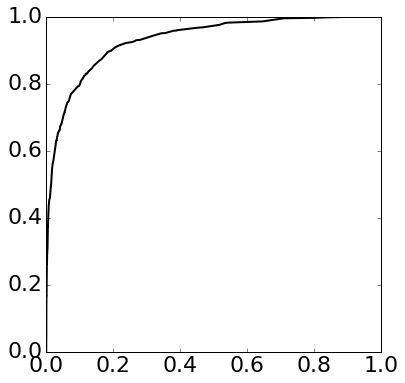

In [236]:
fig = plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')
mpl.rcParams.update({'font.size': 22})
plt.plot(fpr, tpr, 'k-', linewidth=2)

In [237]:
# let's look at the effect of number of rounds of training
test_rounds = np.unique(np.logspace(0, 2, 20, dtype=int))
auc_array = []
for num_round in test_rounds:
    bst = xgb.train(plst, dtrain, num_round, evallist )
    ypred = bst.predict(dtest)
    # do you smell what the roc is cookin' jabroni?
    num_points = 1001
    thresholds = np.linspace(1., 0., num_points)
    tpr = []
    fpr = []
    auc = 0
    for i, t in enumerate(thresholds):
        ypredclass = ypred > t
        tpr.append(sum((y_test == 1) * (ypredclass == 1))/sum(y_test == 1))
        fpr.append(sum((y_test == 0) * (ypredclass == 1))/sum(y_test == 0))
        if i > 0:
            auc = auc + (tpr[-1] + tpr[-2])/2. * (fpr[-1] - fpr[-2])
    auc_array.append(auc)

[0]	eval-error:0.064688	train-error:0.067963
[0]	eval-error:0.064688	train-error:0.067963
[1]	eval-error:0.059853	train-error:0.064691
[0]	eval-error:0.064688	train-error:0.067963
[1]	eval-error:0.059853	train-error:0.064691
[2]	eval-error:0.066189	train-error:0.067796
[0]	eval-error:0.064688	train-error:0.067963
[1]	eval-error:0.059853	train-error:0.064691
[2]	eval-error:0.066189	train-error:0.067796
[3]	eval-error:0.057603	train-error:0.061315
[0]	eval-error:0.064688	train-error:0.067963
[1]	eval-error:0.059853	train-error:0.064691
[2]	eval-error:0.066189	train-error:0.067796
[3]	eval-error:0.057603	train-error:0.061315
[4]	eval-error:0.058269	train-error:0.061231
[0]	eval-error:0.064688	train-error:0.067963
[1]	eval-error:0.059853	train-error:0.064691
[2]	eval-error:0.066189	train-error:0.067796
[3]	eval-error:0.057603	train-error:0.061315
[4]	eval-error:0.058269	train-error:0.061231
[5]	eval-error:0.058603	train-error:0.061169
[0]	eval-error:0.064688	train-error:0.067963
[1]	eval-e

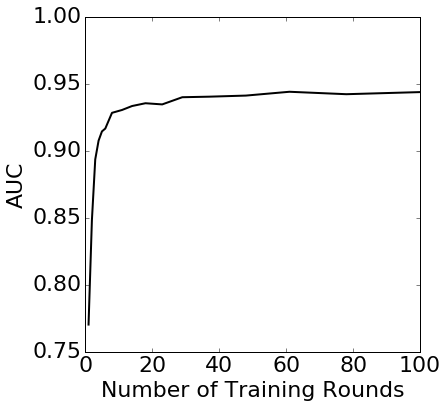

In [238]:
fig = plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')
mpl.rcParams.update({'font.size': 22})
plt.plot(np.array(test_rounds), auc_array, 'k-', linewidth=2)
plt.ylim([.75, 1])
plt.xlabel('Number of Training Rounds')
plt.ylabel('AUC')